1. Load the dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
TARGET_COLUMN = 'class'

df = pd.read_csv('/content/drive/MyDrive/ML_LAB/mail.csv')
print(df.head())
print("Initial shape:", df.shape)

   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_%3B  char_freq_%28  \
0             0.00            0.00  ...           0.00          0.0

2. Perform EDA (class balance, feature distributions).

In [5]:
# HANDLE MISSING VALUES
df = df.dropna(thresh=df.shape[1]//2)  # Drop rows with >50% missing
df.fillna(df.median(numeric_only=True), inplace=True)

# OUTLIER HANDLING (Z-Score)
def remove_outliers(df, threshold=3):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    z_scores = np.abs((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std())
    return df[(z_scores < threshold).all(axis=1)]

df = remove_outliers(df)
# print("After outlier removal:", df.shape)

In [6]:
# FEATURE / TARGET SPLIT
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# ENCODE + STANDARDIZE
numeric_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(exclude=[np.number]).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_encoded)


3. Split into train and test sets.

In [7]:
# TRAIN / VAL / TEST SPLIT
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Train set: (1529, 57)
Validation set: (328, 57)
Test set: (328, 57)


4. Train the following models:

Logistic Regression

Naive Bayes (Gaussian, Multinomial, Bernoulli)

K-Nearest Neighbors (vary k, KDTree, BallTree)

Support Vector Machine (Linear, Polynomial, RBF, Sigmoid kernels)

Decision Tree Classifer

Random Forest Classifer

Adaboost Classifer

Gradient Boost Classifier

Xg Boost Classifier


In [8]:
def evaluate_model(name, model, X_train, X_test, param_grid=None, param_dist=None):

    print(f"\n{name} - Hyperparameter Tuning Started")

    #GRIDSEARCHCV
    if param_grid:
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        print(f"Best Params (GridSearchCV): {grid_search.best_params_}")
        print(f"Best CV Score (GridSearchCV): {grid_search.best_score_:.4f}")
    else:
        grid_search = None

    # RANDOMIZEDSEARCHCV
    if param_dist:
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=10,
            cv=5,
            scoring='accuracy',
            random_state=42,
            n_jobs=-1
        )
        random_search.fit(X_train, y_train)
        print(f"Best Params (RandomizedSearchCV): {random_search.best_params_}")
        print(f"Best CV Score (RandomizedSearchCV): {random_search.best_score_:.4f}")
    else:
        random_search = None

    # PICK BEST MODEL
    if grid_search and random_search:
        best_model = (
            grid_search if grid_search.best_score_ >= random_search.best_score_
            else random_search
        ).best_estimator_
    elif grid_search:
        best_model = grid_search.best_estimator_
    elif random_search:
        best_model = random_search.best_estimator_
    else:
        best_model = model

    #  EVALUATION
    start_time = time.time()
    best_model.fit(X_train, y_train)
    end_time = time.time()

    y_pred = best_model.predict(X_test)
    print(f"\n{name} Performance:")
    print(f"Accuracy :  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision:  {precision_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Recall   :  {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"F1 Score :  {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Training Time: {(end_time - start_time):.4f} seconds")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[0], cmap='Blues')
    axes[0].set_title('Confusion Matrix')

    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='green')
        axes[1].plot([0, 1], [0, 1], linestyle='--', color='blue')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title('ROC Curve')
        axes[1].legend()
        axes[1].grid(True)
    else:
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()


Logistic Regression


Logistic Regression - Hyperparameter Tuning Started


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Performance:
Accuracy :  0.9207
Precision:  0.9287
Recall   :  0.9098
F1 Score :  0.9167
Training Time: 3.7717 seconds


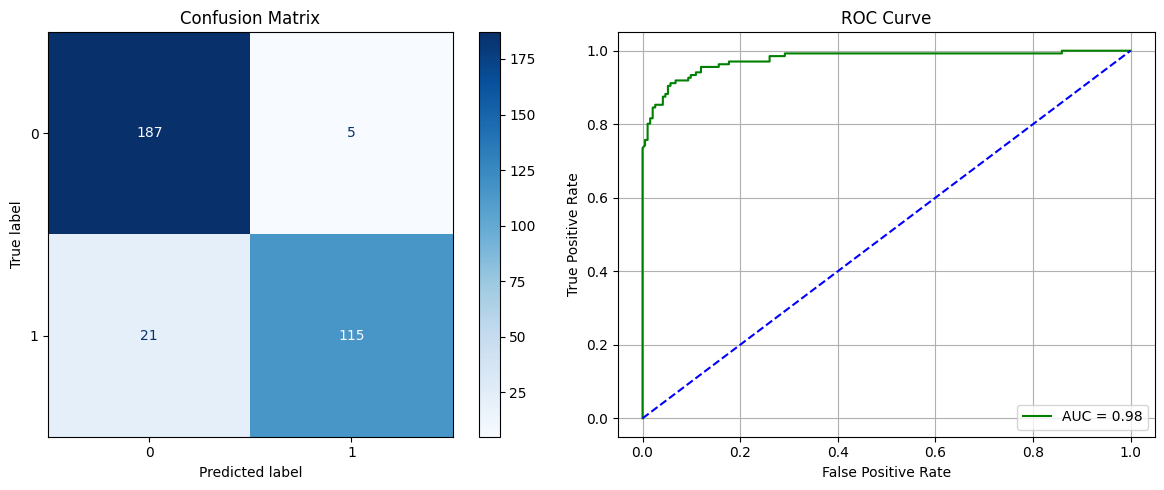

In [9]:
evaluate_model("Logistic Regression", LogisticRegression(max_iter=1000), X_train, X_test)

Naive Bayes - Multinomial


GaussianNB - Hyperparameter Tuning Started

GaussianNB Performance:
Accuracy :  0.8140
Precision:  0.8304
Recall   :  0.8347
F1 Score :  0.8139
Training Time: 0.0070 seconds


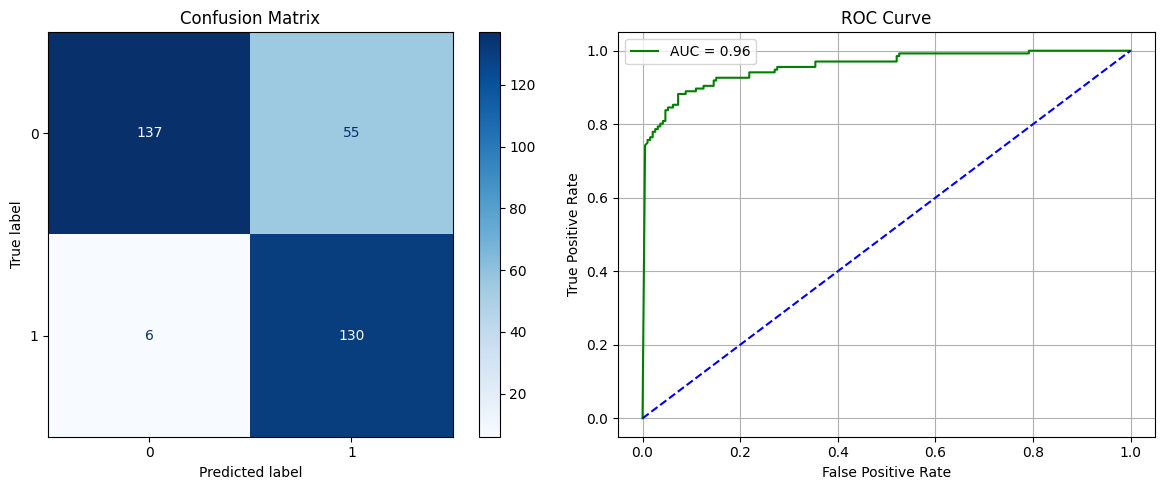

In [10]:
evaluate_model("GaussianNB", GaussianNB(), X_train, X_test)

Naive Bayes - Multinomial


MultinomialNB - Hyperparameter Tuning Started

MultinomialNB Performance:
Accuracy :  0.7744
Precision:  0.7677
Recall   :  0.7665
F1 Score :  0.7671
Training Time: 0.0052 seconds


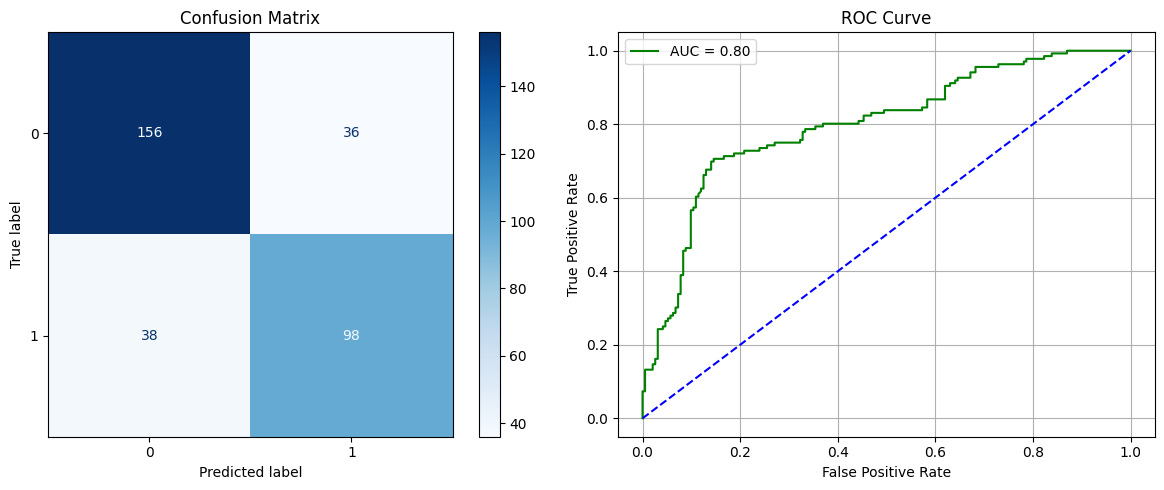

In [11]:
evaluate_model("MultinomialNB", MultinomialNB(), X_train, X_test)

Naive Bayes - Bernoulli


BernoulliNB - Hyperparameter Tuning Started

BernoulliNB Performance:
Accuracy :  0.8811
Precision:  0.8837
Recall   :  0.8706
F1 Score :  0.8756
Training Time: 0.0074 seconds


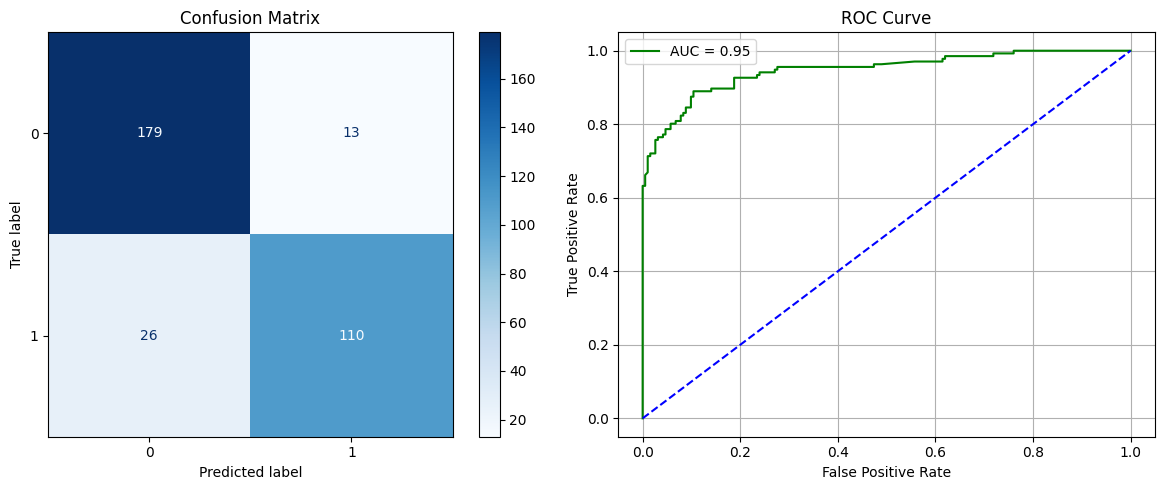

In [12]:
evaluate_model("BernoulliNB", BernoulliNB(), X_train, X_test)

K-Nearest Neighbors - Varying k values [1, 3, 5, 7, 9]


KNN (k=1) - Hyperparameter Tuning Started

KNN (k=1) Performance:
Accuracy :  0.7683
Precision:  0.7616
Recall   :  0.7592
F1 Score :  0.7603
Training Time: 0.0102 seconds


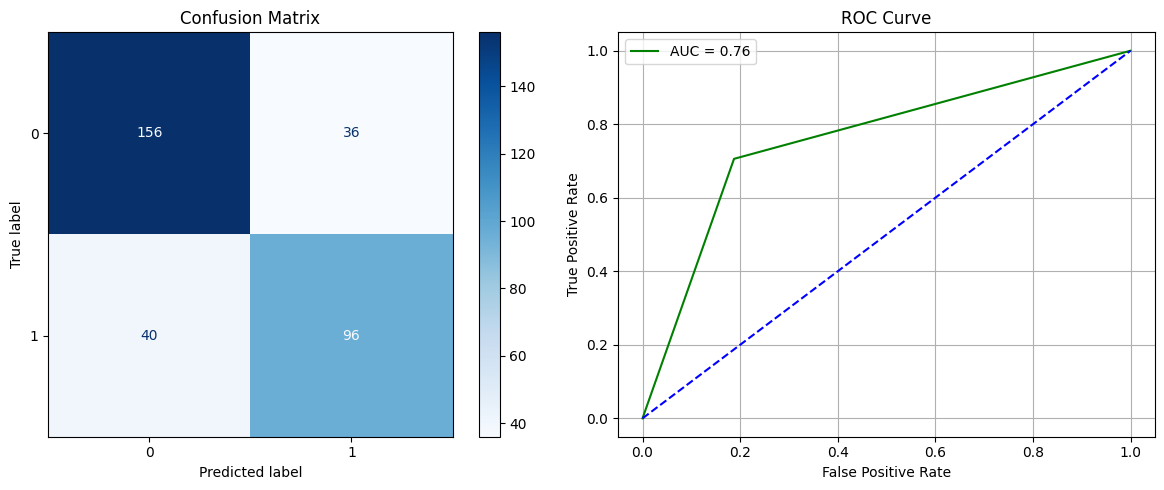


KNN (k=3) - Hyperparameter Tuning Started

KNN (k=3) Performance:
Accuracy :  0.7591
Precision:  0.7524
Recall   :  0.7482
F1 Score :  0.7499
Training Time: 0.0037 seconds


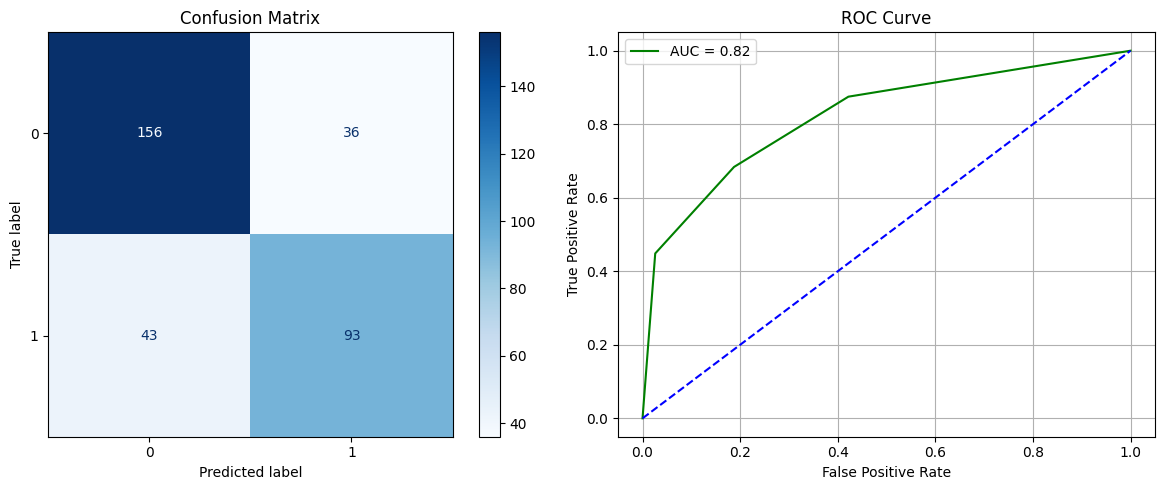


KNN (k=5) - Hyperparameter Tuning Started

KNN (k=5) Performance:
Accuracy :  0.7622
Precision:  0.7572
Recall   :  0.7475
F1 Score :  0.7508
Training Time: 0.0037 seconds


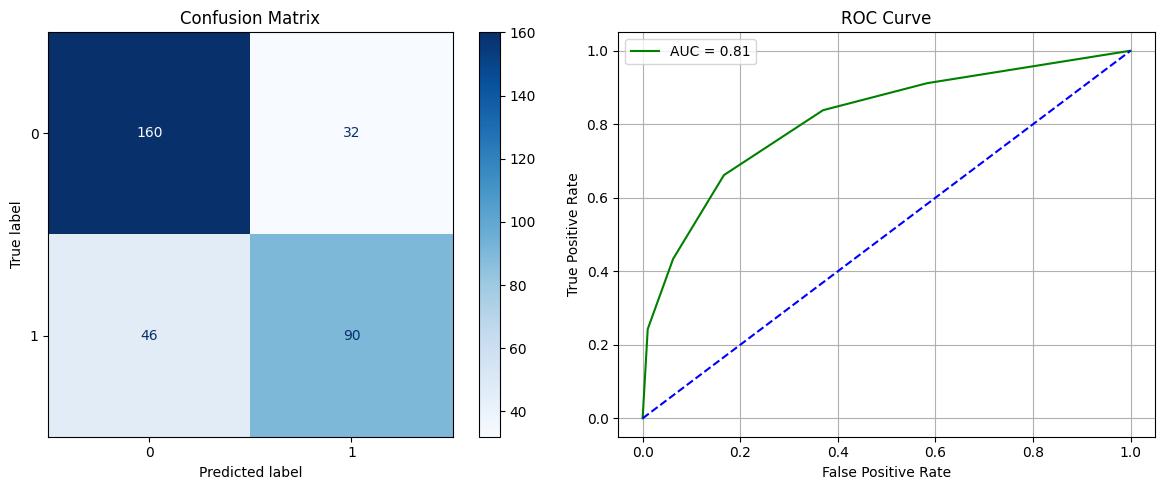


KNN (k=7) - Hyperparameter Tuning Started

KNN (k=7) Performance:
Accuracy :  0.7561
Precision:  0.7528
Recall   :  0.7381
F1 Score :  0.7423
Training Time: 0.0035 seconds


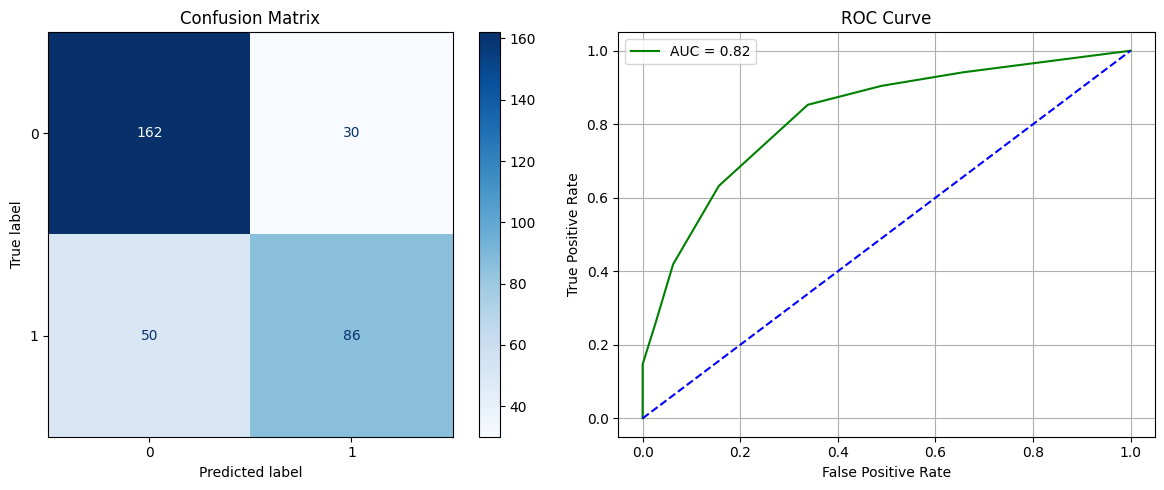


KNN (k=9) - Hyperparameter Tuning Started

KNN (k=9) Performance:
Accuracy :  0.7348
Precision:  0.7322
Recall   :  0.7123
F1 Score :  0.7166
Training Time: 0.0039 seconds


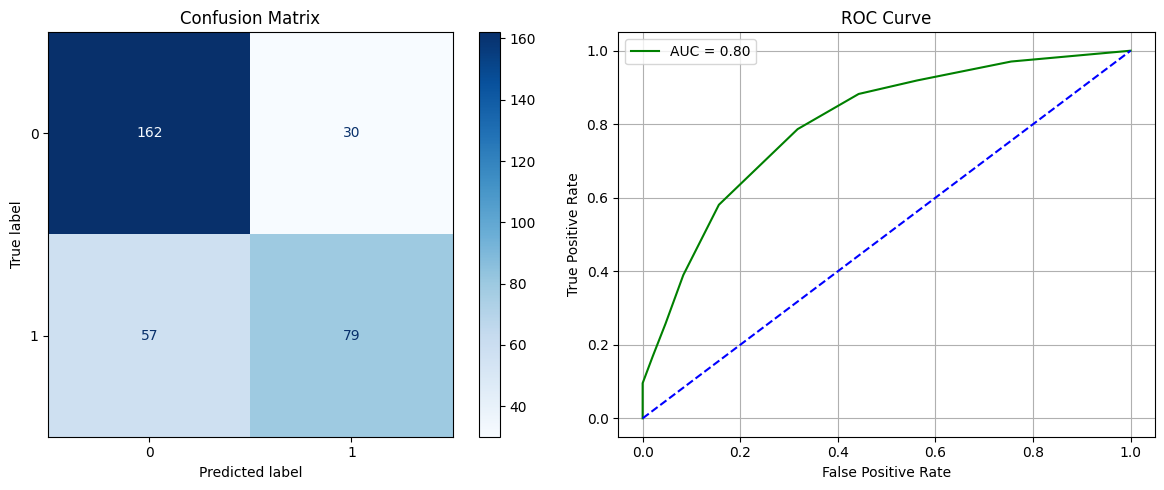

In [13]:
for k in [1, 3, 5, 7, 9]:
    evaluate_model(f"KNN (k={k})", KNeighborsClassifier(n_neighbors=k), X_train, X_test)

K-Nearest Neighbors - KDTree


KNN (KDTree) - Hyperparameter Tuning Started

KNN (KDTree) Performance:
Accuracy :  0.7622
Precision:  0.7572
Recall   :  0.7475
F1 Score :  0.7508
Training Time: 0.0111 seconds


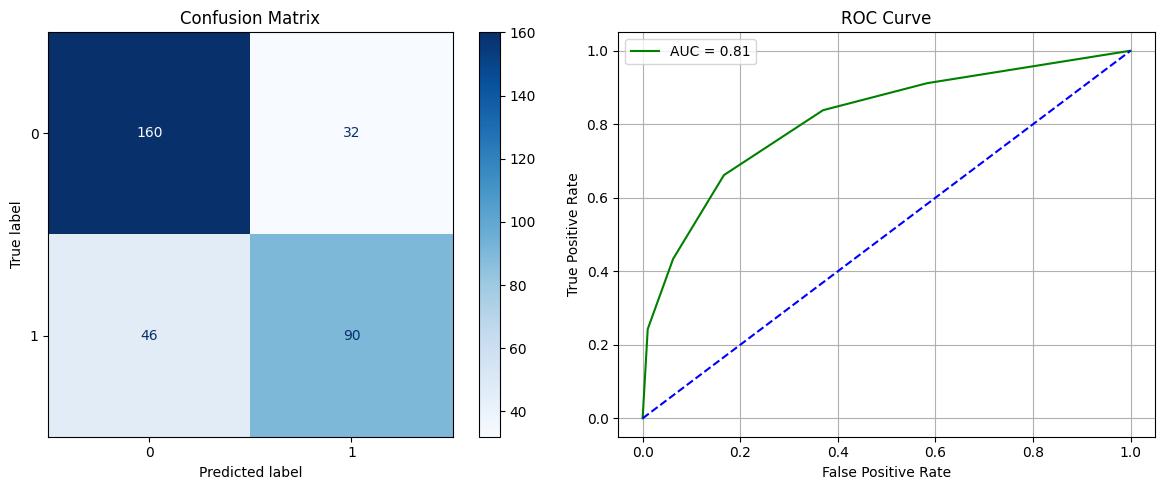

In [14]:
evaluate_model("KNN (KDTree)", KNeighborsClassifier(algorithm='kd_tree'), X_train, X_test)

K-Nearest Neighbors - BallTree


KNN (BallTree) - Hyperparameter Tuning Started

KNN (BallTree) Performance:
Accuracy :  0.7622
Precision:  0.7572
Recall   :  0.7475
F1 Score :  0.7508
Training Time: 0.0082 seconds


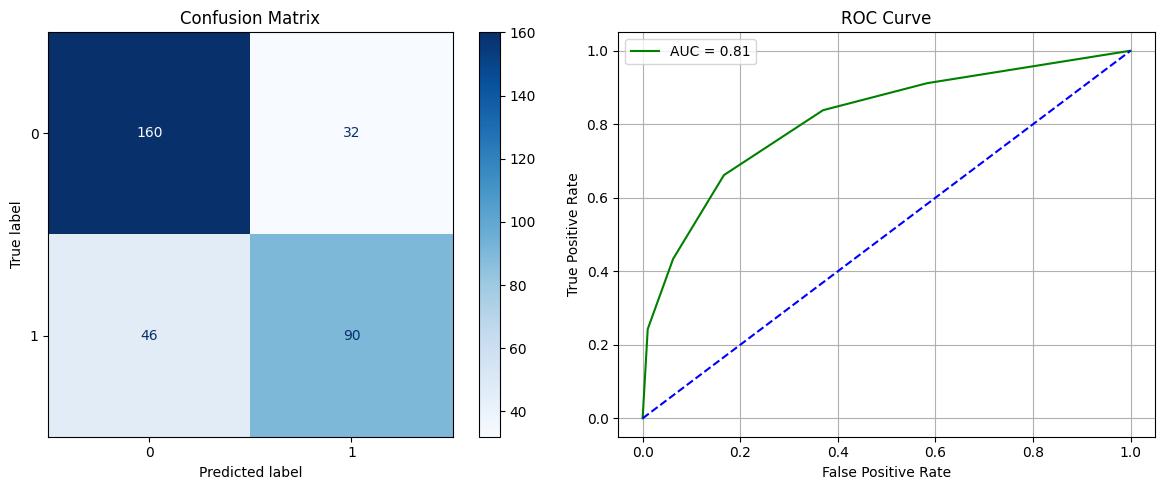

In [15]:
evaluate_model("KNN (BallTree)", KNeighborsClassifier(algorithm='ball_tree'), X_train, X_test)

Support Vector Classifier

SVC- Linear kernel


SVC (Linear) - Hyperparameter Tuning Started

SVC (Linear) Performance:
Accuracy :  0.9268
Precision:  0.9353
Recall   :  0.9161
F1 Score :  0.9231
Training Time: 301.7752 seconds


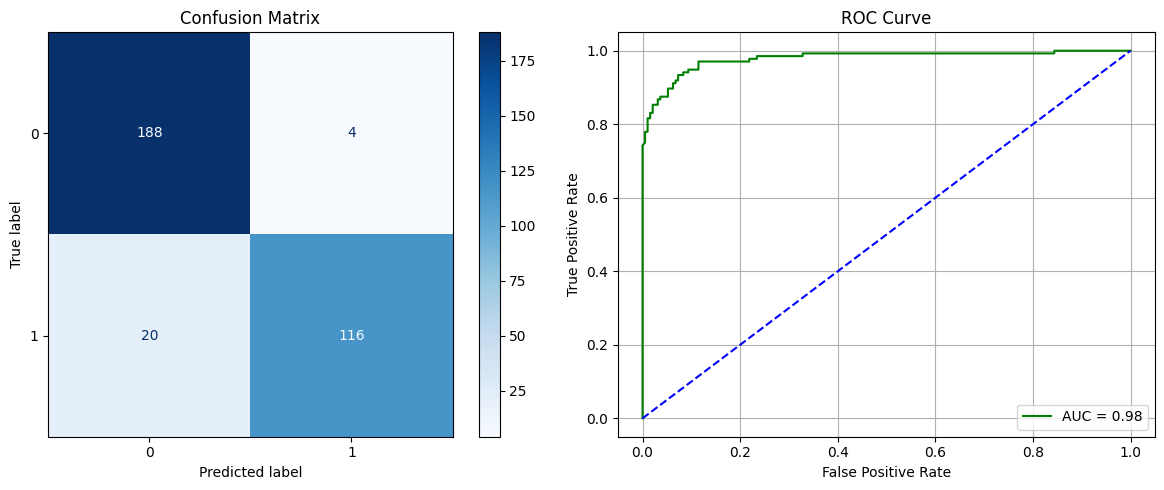

In [26]:
svc_linear = SVC(kernel='linear', C=1.0, probability=True)
evaluate_model("SVC (Linear)", svc_linear, X_train, X_test)

SVC- Polynomial kernel


SVC (Poly) - Hyperparameter Tuning Started

SVC (Poly) Performance:
Accuracy :  0.6524
Precision:  0.8137
Recall   :  0.5809
F1 Score :  0.5248
Training Time: 2.2538 seconds


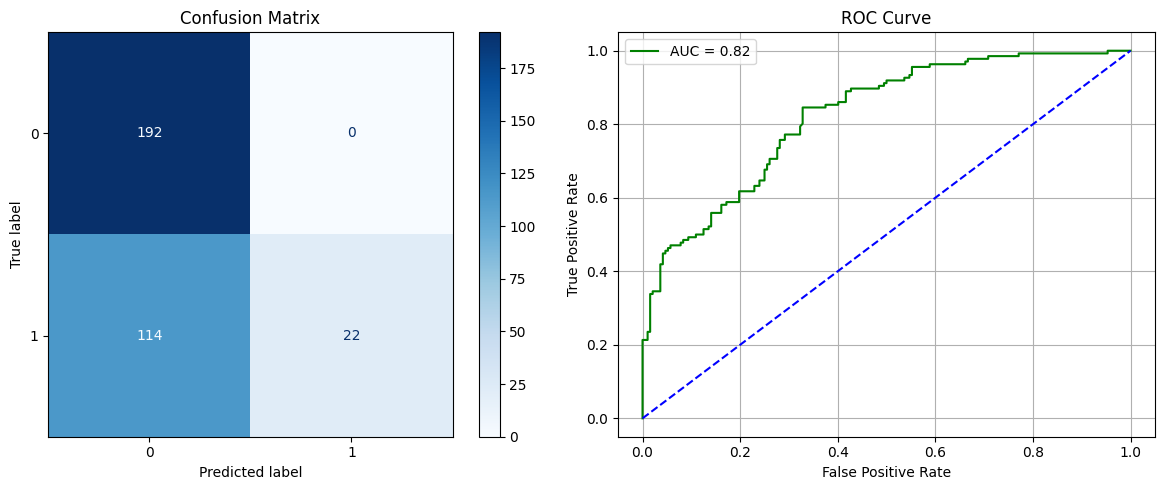

In [17]:
svc_poly = SVC(kernel='poly', C=1.0, degree=3, gamma='scale', probability=True)
evaluate_model("SVC (Poly)", svc_poly, X_train, X_test)

SVC- RBF kernel


SVC (RBF Kernel) - Hyperparameter Tuning Started

SVC (RBF Kernel) Performance:
Accuracy :  0.7165
Precision:  0.7742
Recall   :  0.6667
F1 Score :  0.6607
Training Time: 0.6759 seconds


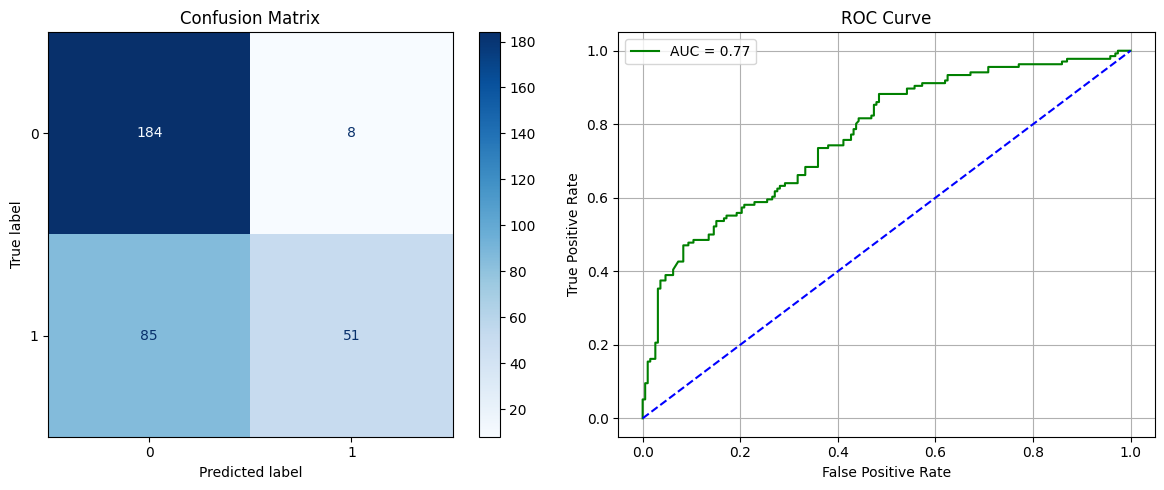

In [18]:
svc_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
evaluate_model("SVC (RBF Kernel)", svc_model, X_train, X_test)

SVC- Sigmoid kernel


SVC (Sigmoid) - Hyperparameter Tuning Started

SVC (Sigmoid) Performance:
Accuracy :  0.5366
Precision:  0.5178
Recall   :  0.5173
F1 Score :  0.5170
Training Time: 0.6439 seconds


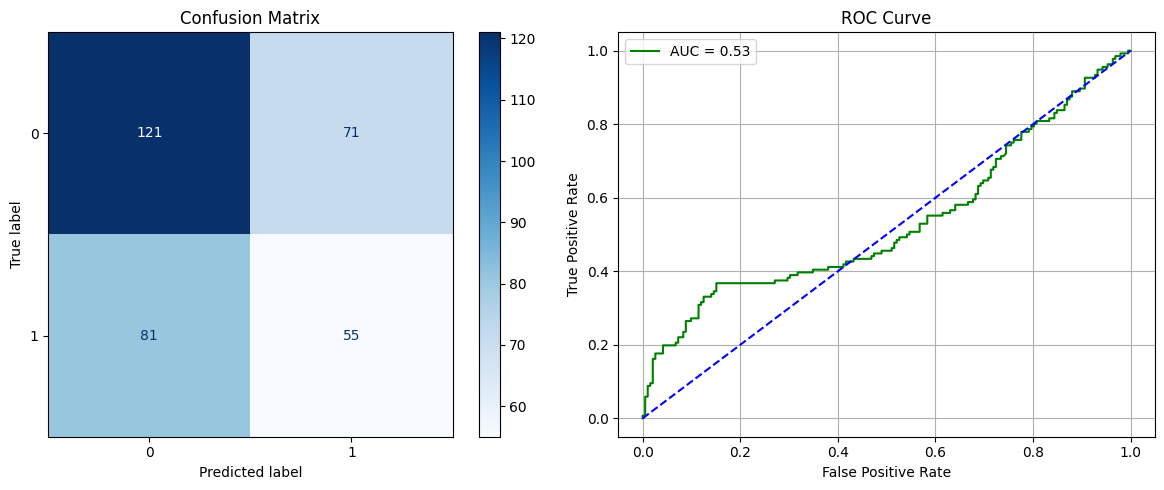

In [19]:
svc_sigmoid = SVC(kernel='sigmoid', C=1.0, gamma='scale', probability=True)
evaluate_model("SVC (Sigmoid)", svc_sigmoid, X_train, X_test)

Decision Tree Classifer


Decision Tree Classifier - Hyperparameter Tuning Started
Best Params (GridSearchCV): {'max_depth': 10, 'min_samples_leaf': 1}
Best CV Score (GridSearchCV): 0.9019

Decision Tree Classifier Performance:
Accuracy :  0.8872
Precision:  0.8889
Recall   :  0.8779
F1 Score :  0.8823
Training Time: 0.0287 seconds


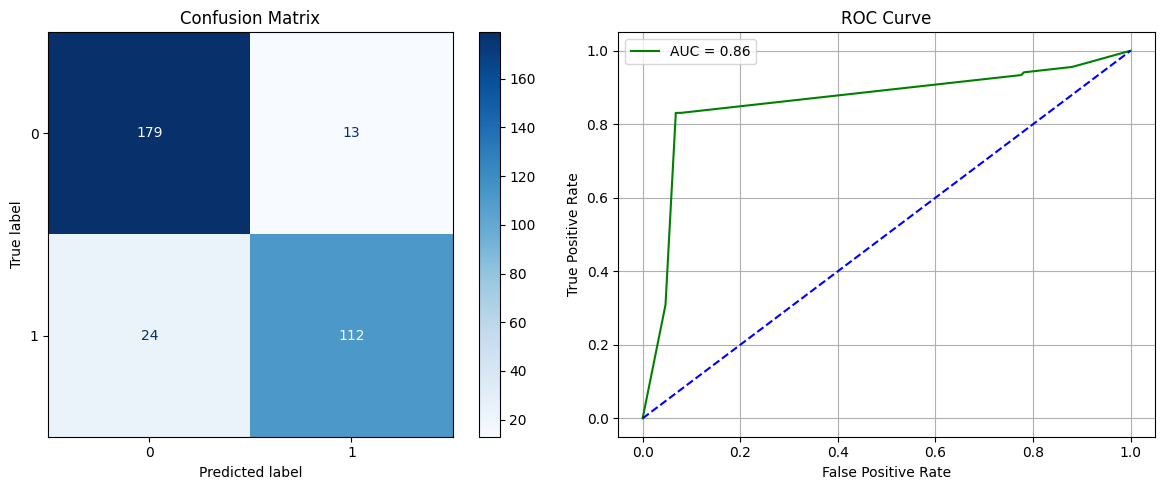

In [20]:
dt_model = DecisionTreeClassifier(random_state=42)
param_grid_dt = {'max_depth': [3, 5, 7, 10], 'min_samples_leaf': [1, 5, 10]}
evaluate_model("Decision Tree Classifier", dt_model, X_train, X_test, param_grid=param_grid_dt)

Random Forest Classifier


Random Forest Classifier - Hyperparameter Tuning Started
Best Params (GridSearchCV): {'max_depth': None, 'n_estimators': 200}
Best CV Score (GridSearchCV): 0.9418

Random Forest Classifier Performance:
Accuracy :  0.9329
Precision:  0.9366
Recall   :  0.9256
F1 Score :  0.9301
Training Time: 0.8438 seconds


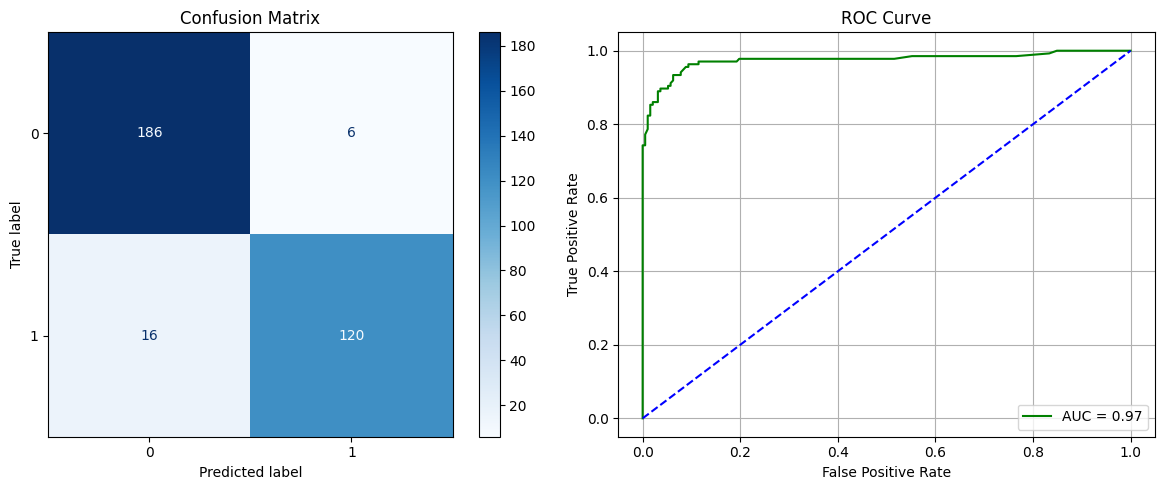

In [21]:
rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}
evaluate_model("Random Forest Classifier", rf_model, X_train, X_test, param_grid=param_grid_rf)

AdaBoost Classifier


AdaBoost Classifier - Hyperparameter Tuning Started
Best Params (GridSearchCV): {'learning_rate': 1.0, 'n_estimators': 200}
Best CV Score (GridSearchCV): 0.9281

AdaBoost Classifier Performance:
Accuracy :  0.9299
Precision:  0.9291
Recall   :  0.9262
F1 Score :  0.9275
Training Time: 1.0612 seconds


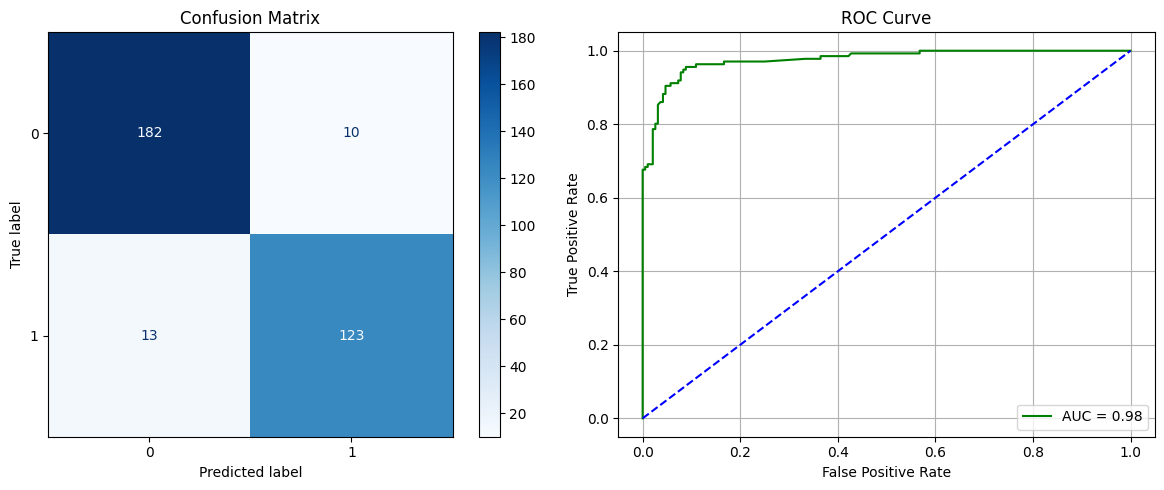

In [23]:
ada_model = AdaBoostClassifier(random_state=42)
param_grid_ada = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}
evaluate_model("AdaBoost Classifier", ada_model, X_train, X_test, param_grid=param_grid_ada)

Gradient Boosting Classifier


Gradient Boosting Classifier - Hyperparameter Tuning Started
Best Params (GridSearchCV): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best CV Score (GridSearchCV): 0.9477

Gradient Boosting Classifier Performance:
Accuracy :  0.9329
Precision:  0.9318
Recall   :  0.9298
F1 Score :  0.9308
Training Time: 2.9370 seconds


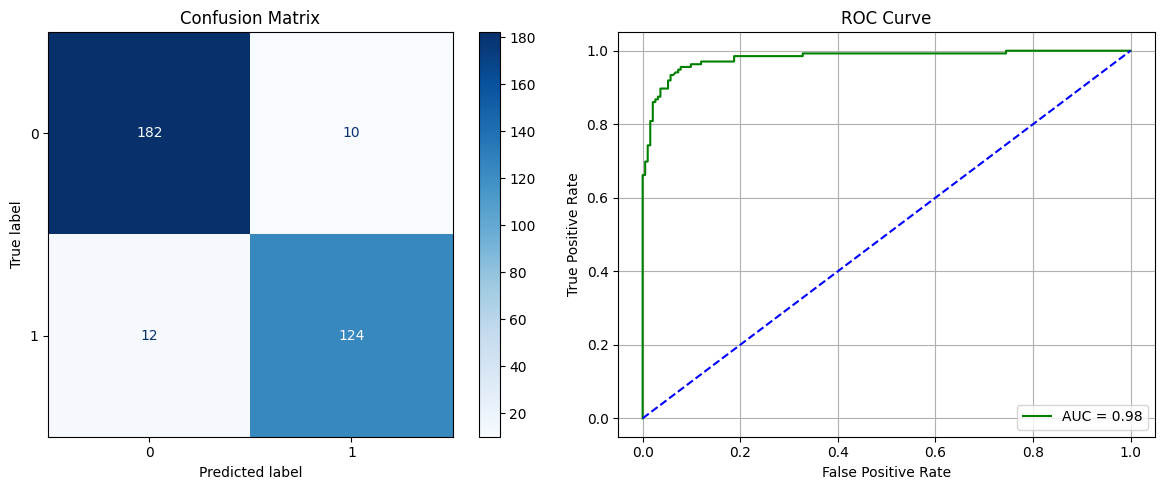

In [24]:
gbt_model = GradientBoostingClassifier(random_state=42)
param_grid_gbt = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
evaluate_model("Gradient Boosting Classifier", gbt_model, X_train, X_test, param_grid=param_grid_gbt)


XGBoost Classifier


XGBoost Classifier - Hyperparameter Tuning Started


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:04:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Params (GridSearchCV): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best CV Score (GridSearchCV): 0.9483


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:04:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classifier Performance:
Accuracy :  0.9421
Precision:  0.9417
Recall   :  0.9387
F1 Score :  0.9401
Training Time: 0.2667 seconds


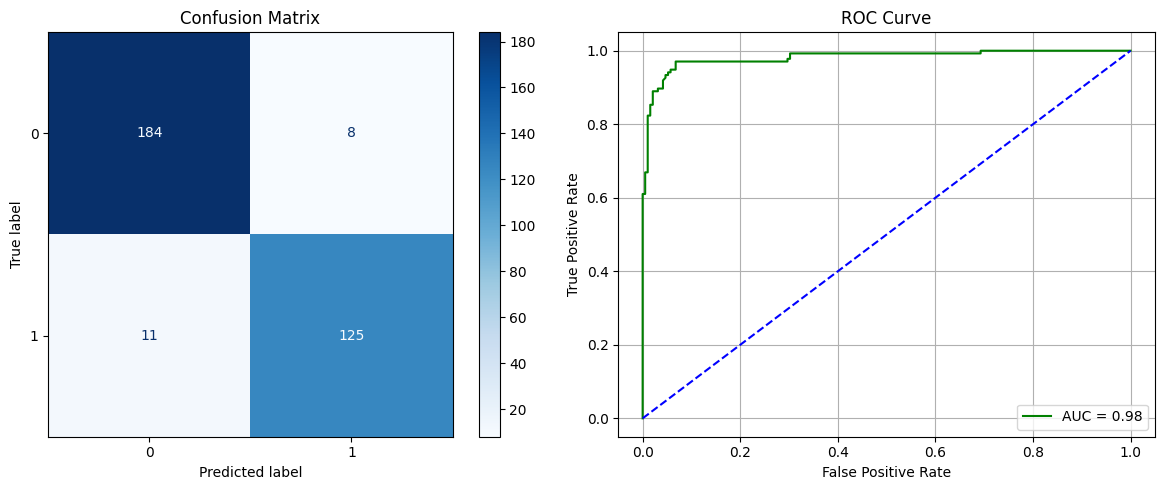

In [25]:
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
param_grid_xgb = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
evaluate_model("XGBoost Classifier", xgb_model, X_train, X_test, param_grid=param_grid_xgb)